# KNN MSE Loss - example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from torch.optim import SGD
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from src.experiments import run_training_loop
from src.networks import CustomNeuralNetwork
from src.losses import KNNMSELoss
from src.utils import plot_values

In [5]:
# Load and normalize the trainig data
data = load_boston()
x, y = data['data'], data['target']
x = MinMaxScaler().fit_transform(x)

In [6]:
# Split data into train/test sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

In [7]:
x = torch.from_numpy(np.ascontiguousarray(x, dtype=np.float32))
y = torch.tensor(y.tolist(), dtype=torch.float32).reshape(-1, 1)

train_x = torch.from_numpy(np.ascontiguousarray(train_x, dtype=np.float32))
train_y = torch.tensor(train_y.tolist(), dtype=torch.float32).reshape(-1,1)

test_x = torch.from_numpy(np.ascontiguousarray(test_x, dtype=np.float32))
test_y = torch.tensor(test_y.tolist(), dtype=torch.float32).reshape(-1,1)

val_x = torch.from_numpy(np.ascontiguousarray(val_x, dtype=np.float32))
val_y = torch.tensor(val_y.tolist(), dtype=torch.float32).reshape(-1,1)

In [8]:
train_dataloader = DataLoader(TensorDataset(train_x, train_y), batch_size=32, shuffle=True)
val_dataloader = DataLoader(TensorDataset(test_x, test_y), batch_size=32)
test_dataloader = DataLoader(TensorDataset(test_x, test_y), batch_size=1)

In [20]:
# Grid search
losses = [('MSELoss', MSELoss(), False)]
for k in [1, 3, 5]:
    losses.append((f'KNNMSELoss (K={k})', KNNMSELoss(x, y, k=k), True))

In [21]:
from tqdm import tqdm_notebook as tqdm

# Training loop
output_data = []

for lossname, lossfunc, knn_loss in losses:
    
    model = CustomNeuralNetwork(layers=[13, 16, 4, 1], hidden_activations="relu")
    optimizer = SGD(model.parameters(), lr=0.001)
    criterion = lossfunc
    
    model, train_loss, test_loss = run_training_loop(
        optimizer, 
        criterion, 
        model, 
        train_dataloader, 
        val_dataloader, 
        epochs=500, 
        use_wandb=False, 
        knn_loss=knn_loss, 
        tqdm_description=lossname
    )
    
    output_data.append((model, train_loss, test_loss))

KNNMSELoss (K=5): 100%|██████████| 500/500 [00:37<00:00, 13.32it/s, val loss=1.6] 


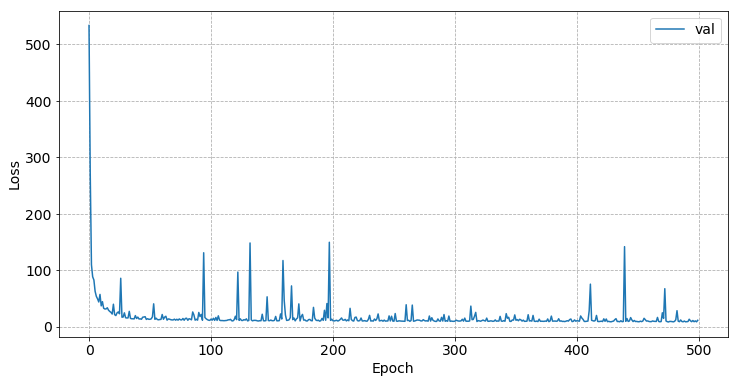

In [22]:
# Base line (HingeLoss)
model, tloss, vloss = output_data[0]
plot_values({'val': vloss})

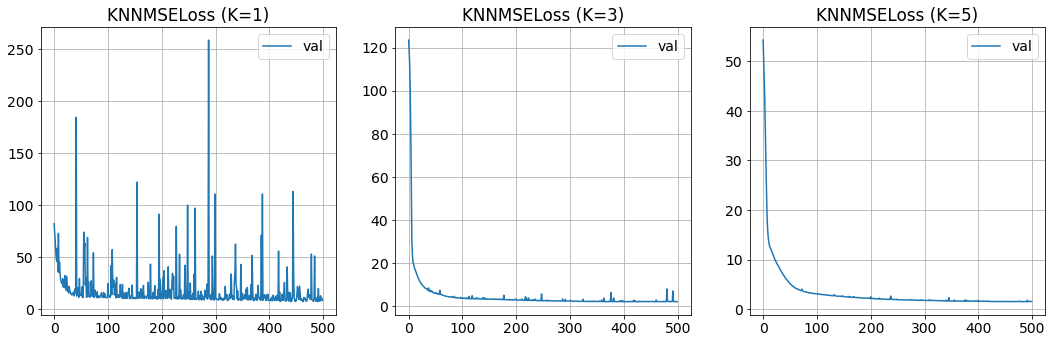

In [23]:
# KNN Hinge Loss
plt.figure(figsize=(18, 18))
for idx, (model, tloss, vloss) in enumerate(output_data[1:]):
    plt.subplot(3, 3, idx + 1)
    plt.grid('on')
    #plt.plot(tloss, label='train')
    plt.plot(vloss, label='val')
    plt.legend()
    plt.title(losses[idx + 1][0])

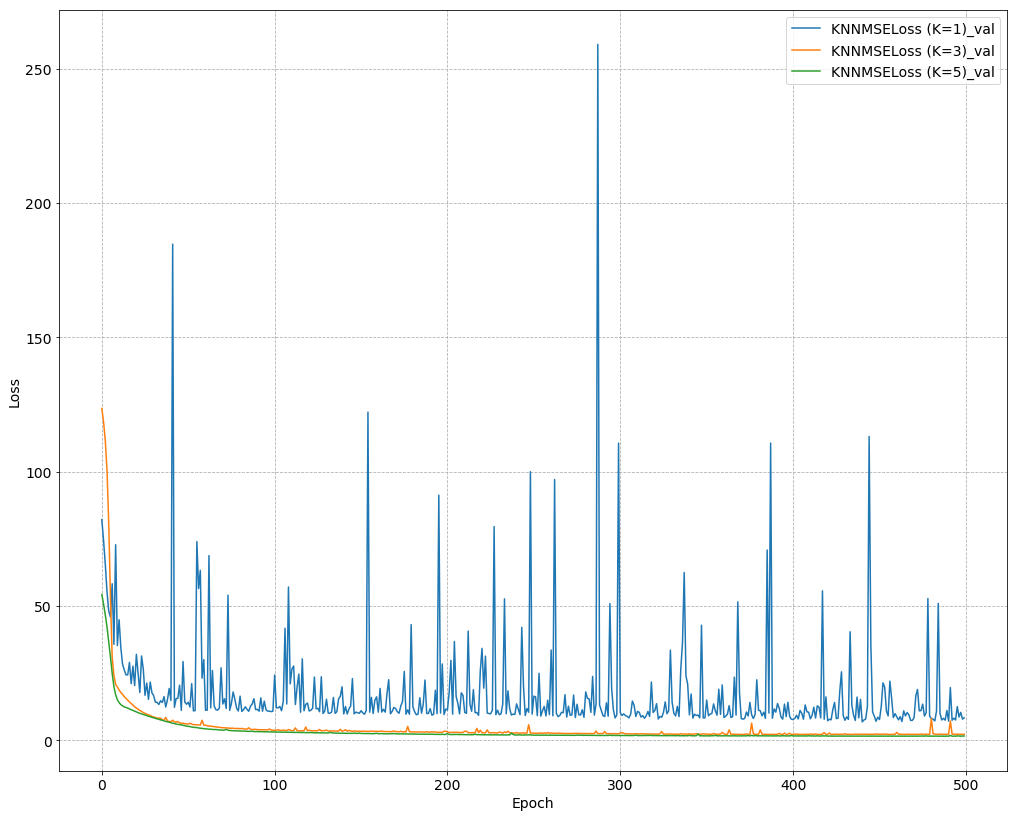

In [24]:
plot_all_data = {}
for idx, (model, tloss, vloss) in enumerate(output_data[1:]):
    plot_all_data[losses[idx + 1][0] + "_val"] = vloss
plot_values(plot_all_data, size=(17, 14))

In [25]:
# Evaluate output
for idx, (model, tloss, vloss) in enumerate(output_data):
    model_name = losses[idx][0]
    gt, predictions = [], []
    print(f'{model_name} / mse: {MSELoss()(model(test_x), test_y)}')

MSELoss / mse: 13.48887825012207
KNNMSELoss (K=1) / mse: 9.73430347442627
KNNMSELoss (K=3) / mse: 12.100141525268555
KNNMSELoss (K=5) / mse: 16.063236236572266
